# 01 Multidimensional multi Knapsack Problem

> **IMPORTANT NOTE**: For this LAB1, I have provided two different solution representations for the MMKP problem:
> 1. A 2-D boolean array of shape (NUM_KNAPSACKS, NUM_ITEMS).
> 2. A 1-D integer array of shape (NUM_ITEMS,).
> The reason it was because I first started with the 2-D boolean array representation, but later realized that the 1-D integer array representation is more efficient and easier to work with. Therefore, I switched to the 1-D integer array representation for the final implementation. However, I have kept both representations in the code for reference and comparison.

## Problem Overview

The multidimensional multi knapsack problem (MMKP) is a generalization of the classic knapsack problem. In this problem, we have multiple knapsacks, each with its own capacity constraints across multiple dimensions (e.g., weight, volume, etc.). We also have a set of items, each with a value and a set of weights corresponding to each dimension. The goal is to maximize the total value of the items placed in the knapsacks without exceeding the capacity constraints of any knapsack in any dimension. 

### Attributes
- The `CONSTRAINTS` array define for each knapsack, what is the maximum weight and what volume it can carry.
- The `WEIGHTS` array defines for each item, what are the dimensions of the item (weight, volume, ...).
- The `VALUES` array defines for each item, what is its value.

### Example Output

with 3 kapsacks and 10 items with 2 dimensions (weight and volume):

```bash
(array([[287, 117],
        [319, 114],
        [204, 244]]),
 array([[52, 69],
        [13, 86],
        [89, 76],
        [54, 52],
        [25, 89],
        [ 5, 87],
        [50, 19],
        [97, 60],
        [85, 27],
        [97, 79]]),
 array([64, 73, 52, 71,  0, 95,  0, 34, 31, 21]))
```

> Note: It is need less to say that the items are the indecises of the arrays like 0, 1, 2, ..., n-1 in `VALUES` and `WEIGHTS`. **and one items can be in only one knapsack.**

In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
# Problem 1 
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.zeros((NUM_KNAPSACKS, NUM_ITEMS), dtype=bool)
# 
ACTION_SET = ['add','remove','swap']

In [ ]:
def value(solution : np.ndarray) -> int:
    return (VALUES * np.any(solution, axis=0)).sum()

def valid(solution : np.ndarray) -> bool:
    # return np.all(solution@WEIGHTS <= CONSTRAINTS)
    for k in range(NUM_KNAPSACKS):
        if np.any(solution[k]@WEIGHTS > CONSTRAINTS[k]):
            return False
    return True
    # for k in range(NUM_KNAPSACKS):
    #     for d in range(NUM_DIMENSIONS):
    #         if np.sum(solution[k] * WEIGHTS[:, d]) > CONSTRAINTS[k, d]:
    #             return False
    # return True

def get_items_left(solution: np.ndarray):
    '''
    Since each item can only be in one knapsack, we just check indices of current solution for all knapsacks are empty, if so, that item is left outside of knapsacks.
    '''
    items_in_knapsacks = np.any(solution != 0, axis=0)
    return np.nonzero(~items_in_knapsacks)[0]

def get_items_in(solution: np.ndarray):
    '''
    Same idea as get_items_left function, but here we return indices of items that are in knapsacks.
    '''
    items_in_knapsacks = np.any(solution != 0, axis=0)
    return np.nonzero(items_in_knapsacks)[0]

In [4]:
def action_tweak(solution: np.ndarray, action : str) -> np.ndarray:

    assert action in ACTION_SET, f"Action must be one of {ACTION_SET}"

    new_solution = solution.copy()

    if action == 'add':
        items_left = get_items_left(new_solution)
        if len(items_left) == 0:
            return new_solution, action
        item_to_add = rng.choice(items_left)
        knapsack_to_add = rng.integers(0, NUM_KNAPSACKS)
        new_solution[knapsack_to_add, item_to_add] = True
    elif action == 'remove':
        items_in = get_items_in(new_solution)
        if len(items_in) == 0:
            return new_solution, action
        item_to_remove = rng.choice(items_in)
        knapsack_to_remove = np.where(new_solution[:, item_to_remove])[0][0] # find which knapsack has this item
        new_solution[knapsack_to_remove, item_to_remove] = False
    elif action == 'swap':
        items_in = get_items_in(new_solution)
        if len(items_in) > 1:
            item_to_remove = rng.choice(items_in, size=2, replace=False)
            knapsack_to_remove_1 = np.where(new_solution[:, item_to_remove[0]])[0][0]
            knapsack_to_remove_2 = np.where(new_solution[:, item_to_remove[1]])[0][0]
            new_solution[knapsack_to_remove_1, item_to_remove[0]] = False
            new_solution[knapsack_to_remove_2, item_to_remove[1]] = False
            new_solution[knapsack_to_remove_1, item_to_remove[1]] = True
            new_solution[knapsack_to_remove_2, item_to_remove[0]] = True
        else:
            return new_solution, action

    
    return new_solution, action

In [ ]:
def test_tweak(solution):
    new_solution = solution.copy()
    for _ in range(5):
        new_solution, act = action_tweak(new_solution, action=rng.choice(ACTION_SET, p=[0.6,0.1,0.3]))
        items_left = get_items_left(new_solution)
        print("Action:", act)
        print("Items left:", items_left, "Count:", len(items_left))
        print("Items in:", get_items_in(new_solution), "Count:", len(get_items_in(new_solution)))
        print("Value:", value(new_solution))
        print("Valid:", valid(new_solution))
        print(20 * "-")
        # print(new_solution)
    return new_solution
n_s = test_tweak(solution)

In [6]:
def hill_climbing(solution: np.ndarray, max_iter=1000, actions_set=(ACTION_SET,None)) -> tuple[np.ndarray, int, int, dict]:
    '''
    Hill climbing algorithm to optimize the knapsack solution.
    Parameters:
        - solution: initial solution to start the hill climbing from.
        - max_iter: maximum number of iterations to perform.
        - actions_set: tuple of (list of actions, list of probabilities) to choose from
    Returns:
        - best_solution: the best solution found.
        - best_value: the value of the best solution.
        - items_left: number of items left unassigned in the best solution.
        - history: dictionary containing the history of values and items left during the iterations.
    '''
    best_solution = solution.copy()
    best_value = value(best_solution)
    
    history = {
        'value' : [],
        'items_left' : [],
    }

    for iteration in tqdm(range(max_iter), desc="Hill Climbing"):

        new_solution, _ = action_tweak(best_solution, 
                                       action=rng.choice(actions_set[0], p=actions_set[1] if actions_set[1] is not None else None))
        

        items_left = len(get_items_left(new_solution))
        
        if items_left == 0:
            print("All items assigned!")
            return new_solution, value(new_solution), items_left, history
        
        if valid(new_solution):
            new_value = value(new_solution)
            if new_value > best_value:
                best_value = new_value
                best_solution = new_solution
                
            elif new_value == best_value:
                best_solution = new_solution
            
        history['value'].append(best_value)
        history['items_left'].append(items_left)

        
    return best_solution, best_value, items_left, history

# Probem 1 Configuration

In [7]:
# Problem 1 
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.array(
    [[False for _ in range(NUM_ITEMS)] for _ in range(NUM_KNAPSACKS)] , dtype=np.bool
)

best_solution, best_value, items_left_num, history = hill_climbing(solution, max_iter=50000, 
                                                            actions_set=(['add','remove','swap'], [0.5,0.1,0.4])
                                                            )
print(100 * "-")
print("Best value found for problem 1:", best_value)
if items_left_num != 0:
    print("But there are still", items_left_num, "items left unassigned.")

Hill Climbing:   0%|          | 48/50000 [00:00<00:09, 5234.16it/s]

All items assigned!
----------------------------------------------------------------------------------------------------
Best value found for problem 1: 1065


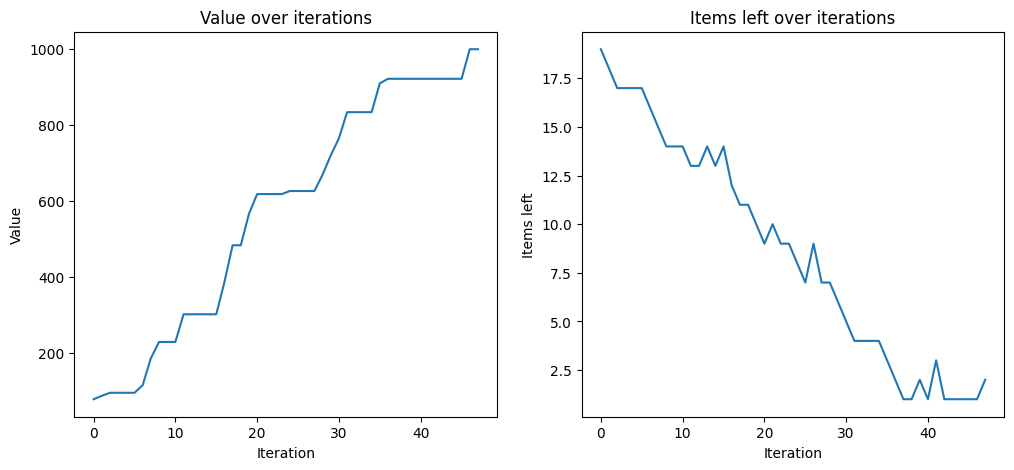

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['value'])
plt.title("Value over iterations")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.subplot(1,2,2)
plt.plot(history['items_left'])
plt.title("Items left over iterations")
plt.xlabel("Iteration")
plt.ylabel("Items left")
plt.show()

# Problem 2 Configuration

In [9]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.array(
    [[False for _ in range(NUM_ITEMS)] for _ in range(NUM_KNAPSACKS)] , dtype=np.bool
)

best_solution, best_value, items_left_num, history = hill_climbing(solution, max_iter=100000,
                                                            actions_set=(['add','remove','swap'], None)
                                                            )
print(100 * "-")
print("Best value found for problem 2:", best_value)
if items_left_num != 0:
    print("But there are still", items_left_num, "items left unassigned.")

Hill Climbing: 100%|██████████| 100000/100000 [00:32<00:00, 3053.05it/s]

----------------------------------------------------------------------------------------------------
Best value found for problem 2: 46205
But there are still 12 items left unassigned.


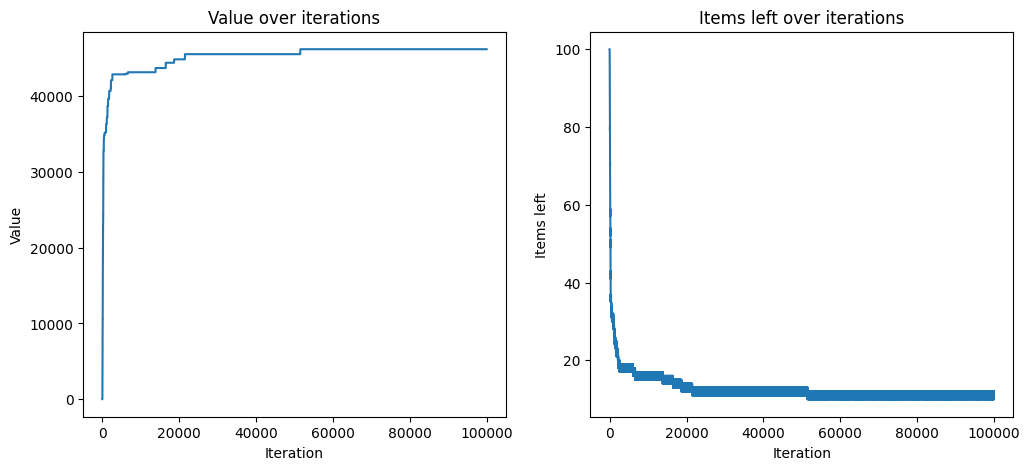

In [10]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['value'])
plt.title("Value over iterations")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.subplot(1,2,2)
plt.plot(history['items_left'])
plt.title("Items left over iterations")
plt.xlabel("Iteration")
plt.ylabel("Items left")
plt.show()

# Problem 3 

In [11]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.array(
    [[False for _ in range(NUM_ITEMS)] for _ in range(NUM_KNAPSACKS)] , dtype=np.bool
)

best_solution, best_value, items_left_num, history = hill_climbing(solution, max_iter=50000,
                                                                        actions_set=(['add','remove','swap'], None))
print(100 * "-")
print("Best value found for problem 3:", best_value)
if items_left_num != 0:
    print("But there are still", items_left_num, "items left unassigned.")

Hill Climbing:   2%|▏         | 790/50000 [02:23<2:28:59,  5.50it/s]


KeyboardInterrupt: 

# Second LAB Solution 

As you can see, when it comes to the Problem 3 configuration, the algorithm takes a lot of time to find a solution. One main reason is because the solution format that we consider as a 2D numpy array of shape (num_knapsacks, num_items), make it many operation over a sparse arrays since each item can be in only one knapsack. Therefore, most of the entries in the solution array are zeros. To tackle this issue, we can consider a different solution representation. Instead of using a 2D array, we can use a 1D array where each index represents an item, and the value at that index represents the knapsack to which the item is assigned and `0` if the item is not assigned to any knapsack. 

### Example :

```bash
# 
array([ 2,  2,  1,  2,  1,  0,  2,  1,  0, -1], dtype=int16)
```


So the below section is an implementation of this idea.

In [ ]:
# test config 
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.full(NUM_ITEMS, -1, dtype=np.int16)
# random solution
# solution = rng.integers(-1, NUM_KNAPSACKS, size=NUM_ITEMS, dtype=np.int16)
# 
ACTION_SET = ['add','remove','swap']

In [52]:
def value(solution: np.ndarray) -> int:
    assigned_items = np.where(solution != -1)[0]
    return VALUES[assigned_items].sum()

def valid(solution: np.ndarray) -> bool:
    for k in range(NUM_KNAPSACKS):
        items_in_k = np.where(solution == k)[0]
        if len(items_in_k) > 0:
            total_weight = WEIGHTS[items_in_k].sum(axis=0)
            if np.any(total_weight > CONSTRAINTS[k]):
                return False
    return True

def get_items_left(solution: np.ndarray):
    return np.where(solution == -1)[0]

def get_items_in(solution: np.ndarray):
    return np.where(solution != -1)[0]

In [ ]:
def action_tweak(solution: np.ndarray, action: str) -> np.ndarray:
    
    assert action in ACTION_SET, f"Action must be one of {ACTION_SET}"
    
    new_solution = solution.copy()
    
    if action == 'add':
        items_left = get_items_left(new_solution)
        if len(items_left) == 0:
            return new_solution, action
        
        item_to_add = rng.choice(items_left)
        knapsack_to_add = rng.integers(0, NUM_KNAPSACKS)
        new_solution[item_to_add] = knapsack_to_add
        
    elif action == 'remove':
        items_in = get_items_in(new_solution)
        if len(items_in) == 0:
            return new_solution, action
        
        item_to_remove = rng.choice(items_in)
        new_solution[item_to_remove] = -1
        
    elif action == 'swap':
        items_in = get_items_in(new_solution)
        if len(items_in) < 2:
            return new_solution, action
        
        item1, item2 = rng.choice(items_in, size=2, replace=False)
        knapsack1 = new_solution[item1]
        knapsack2 = new_solution[item2]
        
        if knapsack1 == knapsack2:
            return new_solution, action
        
        # Swap
        new_solution[item1] = knapsack2
        new_solution[item2] = knapsack1
    
    return new_solution, action

In [40]:
def hill_climbing(solution: np.ndarray, max_iter=1000, actions_set=(ACTION_SET, None)):
    """
    Hill climbing algorithm.
    
    Parameters:
        - solution: initial solution (item -> knapsack mapping)
        - max_iter: maximum iterations
        - actions_set: (actions list, probabilities list)
    
    Returns:
        - best_solution, best_value, items_left, history
    """
    best_solution = solution.copy()
    best_value = value(best_solution)
    
    history = {
        'value': [],
        'items_left': [],
    }

    for iteration in tqdm(range(max_iter), desc="Hill Climbing"):
        new_solution, _ = action_tweak(
            best_solution,
            action=rng.choice(actions_set[0], p=actions_set[1] if actions_set[1] is not None else None)
        )

        items_left = len(get_items_left(new_solution))
        
        if items_left == 0:
            print("All items assigned!")
            return new_solution, value(new_solution), items_left, history
        
        if valid(new_solution):
            new_value = value(new_solution)
            if new_value > best_value:
                best_value = new_value
                best_solution = new_solution
            elif new_value == best_value:
                best_solution = new_solution
        
        history['value'].append(best_value)
        history['items_left'].append(items_left)
    
    return best_solution, best_value, items_left, history

In [47]:
# Problem 1 
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.full(NUM_ITEMS, -1, dtype=np.int16)

best_solution, best_value, items_left_num, history_p1 = hill_climbing(solution, max_iter=50000, 
                                                            actions_set=(['add','remove','swap'], [0.5,0.1,0.4])
                                                            )
print(100 * "-")
print("Best value found for problem 1:", best_value)
if items_left_num != 0:
    print("But there are still", items_left_num, "items left unassigned.")

Hill Climbing:   0%|          | 48/50000 [00:00<00:07, 6599.57it/s]

All items assigned!
----------------------------------------------------------------------------------------------------
Best value found for problem 1: 1065


In [50]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)
# inital solution with empty knapsacks
solution = np.full(NUM_ITEMS, -1, dtype=np.int16)

best_solution, best_value, items_left_num, history_p2 = hill_climbing(solution, max_iter=50000,
                                                            actions_set=(['add','remove','swap'], [0.6,0.1,0.3])
                                                            )
print(100 * "-")
print("Best value found for problem 2:", best_value)
if items_left_num != 0:
    print("But there are still", items_left_num, "items left unassigned.")

Hill Climbing: 100%|██████████| 50000/50000 [00:05<00:00, 9338.87it/s]

----------------------------------------------------------------------------------------------------
Best value found for problem 2: 46202
But there are still 11 items left unassigned.


In [51]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

# inital solution with empty knapsacks
solution = np.full(NUM_ITEMS, -1, dtype=np.int16)

best_solution, best_value, items_left_num, history_p3 = hill_climbing(solution, max_iter=50000,
                                                                        actions_set=(['add','remove','swap'], None))
print(100 * "-")
print("Best value found for problem 3:", best_value)
if items_left_num != 0:
    print("But there are still", items_left_num, "items left unassigned.")

Hill Climbing: 100%|██████████| 50000/50000 [01:03<00:00, 785.42it/s]

----------------------------------------------------------------------------------------------------
Best value found for problem 3: 1408767
But there are still 2196 items left unassigned.


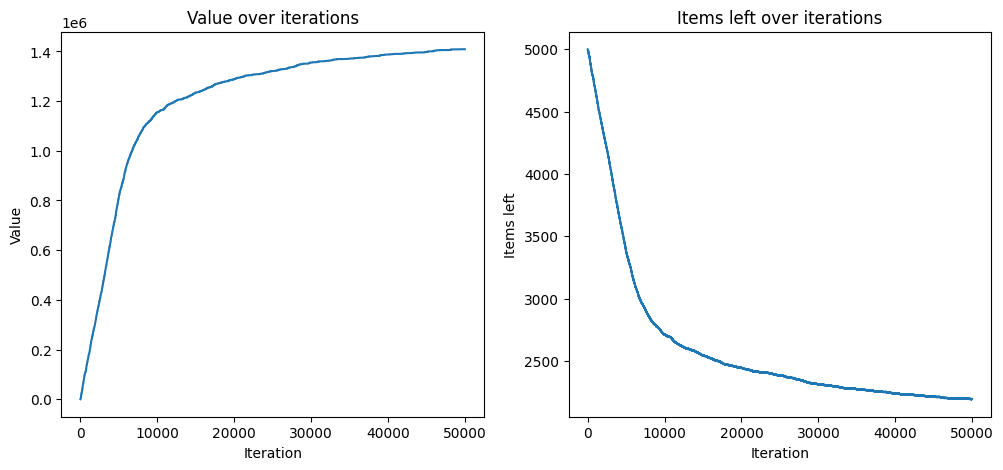

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_p3['value'])
plt.title("Value over iterations")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.subplot(1,2,2)
plt.plot(history_p3['items_left'])
plt.title("Items left over iterations")
plt.xlabel("Iteration")
plt.ylabel("Items left")
plt.show()